# Libraries

In [4]:
from  google.colab  import  drive 
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import scipy
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics.pairwise as pw
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import random
from scipy import sparse
from scipy.stats import pearsonr
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
import torch
from torchtext import data
from torchtext import datasets

In [6]:
import torch
from torchtext import data
from torchtext import datasets

# Pre-Processing

In [7]:
restaurants = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Restaurants Reviews/restaurants.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Restaurants Reviews/ratings.csv')
df = restaurants.merge(ratings, how="left", on="RestaurantId")
df.head()

,RestaurantId,Name,UserId,Review,Rating
0,1,aleria,1,A full 5 stars! Phenomenal Michelin ranked res...,5
1,1,aleria,2,We spent great evening here. Cozy restaurant w...,5
2,1,aleria,3,10/10. Aleria was our highlight during our tri...,5
3,1,aleria,4,Great service and fantastic food. We enjoyed e...,5
4,1,aleria,5,Let me put it his way: simply perfect. We hate...,5


In [8]:
del df['RestaurantId']
df

,Name,UserId,Review,Rating
0,aleria,1,A full 5 stars! Phenomenal Michelin ranked res...,5
1,aleria,2,We spent great evening here. Cozy restaurant w...,5
2,aleria,3,10/10. Aleria was our highlight during our tri...,5
3,aleria,4,Great service and fantastic food. We enjoyed e...,5
4,aleria,5,Let me put it his way: simply perfect. We hate...,5
...,...,...,...,...
26203,ydria,1000,"Very good grilled octopus, spinach pie and Sau...",5
26204,ydria,1001,"The food is sensarional, the service is great....",5
26205,ydria,1002,Risotto was excellent. Wine was an extremely s...,4
26206,ydria,1003,We decided to eat here for an afternoon snack ...,5


Για να ταξινομήσω τις θετικές ή τις αρνητικές κριτικές, θα συγκεντρώσω τα ratings 4 και 5 που βαθμολογήθηκαν μαζί ως θετικές και θα τις κωδικοποιήσω ως 2. Θα κωδικοποιήσω τη βαθμολογία 3 ως 0 και τη βαθμολογία 1 και 2 ως 1.

In [9]:
def calc_sentiment_with_neutral(overall):
    if overall == 5 or overall == 4:
        return 2
    elif overall == 1 or overall==2 : 
        return 0
    else:
        return 1

In [10]:
df['sentiment'] = df['Rating'].apply(calc_sentiment_with_neutral)

In [11]:
df.groupby(['sentiment','Rating']).count()

Name  UserId  Review
sentiment Rating                       
0         1         530     530     530
          2         613     613     613
1         3        1382    1382    1382
2         4        4478    4478    4478
          5       19205   19205   19205

In [12]:
df['sentiment'].value_counts()

2    23683
1     1382
0     1143
Name: sentiment, dtype: int64

In [13]:
df['Review']=df['Review'].str.lower()

In [14]:
df['Review']

0        a full 5 stars! phenomenal michelin ranked res...
1        we spent great evening here. cozy restaurant w...
2        10/10. aleria was our highlight during our tri...
3        great service and fantastic food. we enjoyed e...
4        let me put it his way: simply perfect. we hate...
                               ...                        
26203    very good grilled octopus, spinach pie and sau...
26204    the food is sensarional, the service is great....
26205    risotto was excellent. wine was an extremely s...
26206    we decided to eat here for an afternoon snack ...
26207    waiters speak different languages and they are...
Name: Review, Length: 26208, dtype: object

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def remove_punctuation(text):
    #η συνάρτηση χωρίζει τις λέξεις σε γράμματα, αφαιρεί σημεία στίξης και συγκεντρώνει ξανά γράμματα ως λέξεις
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [17]:
df['Review_Clean'] = df['Review'].apply(lambda x: remove_punctuation(x))
df.head()

,Name,UserId,Review,Rating,sentiment,Review_Clean
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...
1,aleria,2,we spent great evening here. cozy restaurant w...,5,2,we spent great evening here cozy restaurant wi...
2,aleria,3,10/10. aleria was our highlight during our tri...,5,2,1010 aleria was our highlight during our trip ...
3,aleria,4,great service and fantastic food. we enjoyed e...,5,2,great service and fantastic food we enjoyed ev...
4,aleria,5,let me put it his way: simply perfect. we hate...,5,2,let me put it his way simply perfect we hate l...


In [18]:
df_pos = df.loc[df['sentiment']==2] # θετικά reviews dataframe
df_neg = df.loc[df['sentiment']==0] # αρνητικά reviews dataframe
df_notr = df.loc[df['sentiment']==1] # neutral reviews dataframe

In [19]:
stop_words = set(STOPWORDS)

In [20]:
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500, max_font_size = 100, random_state = 42, width=800, height=400)

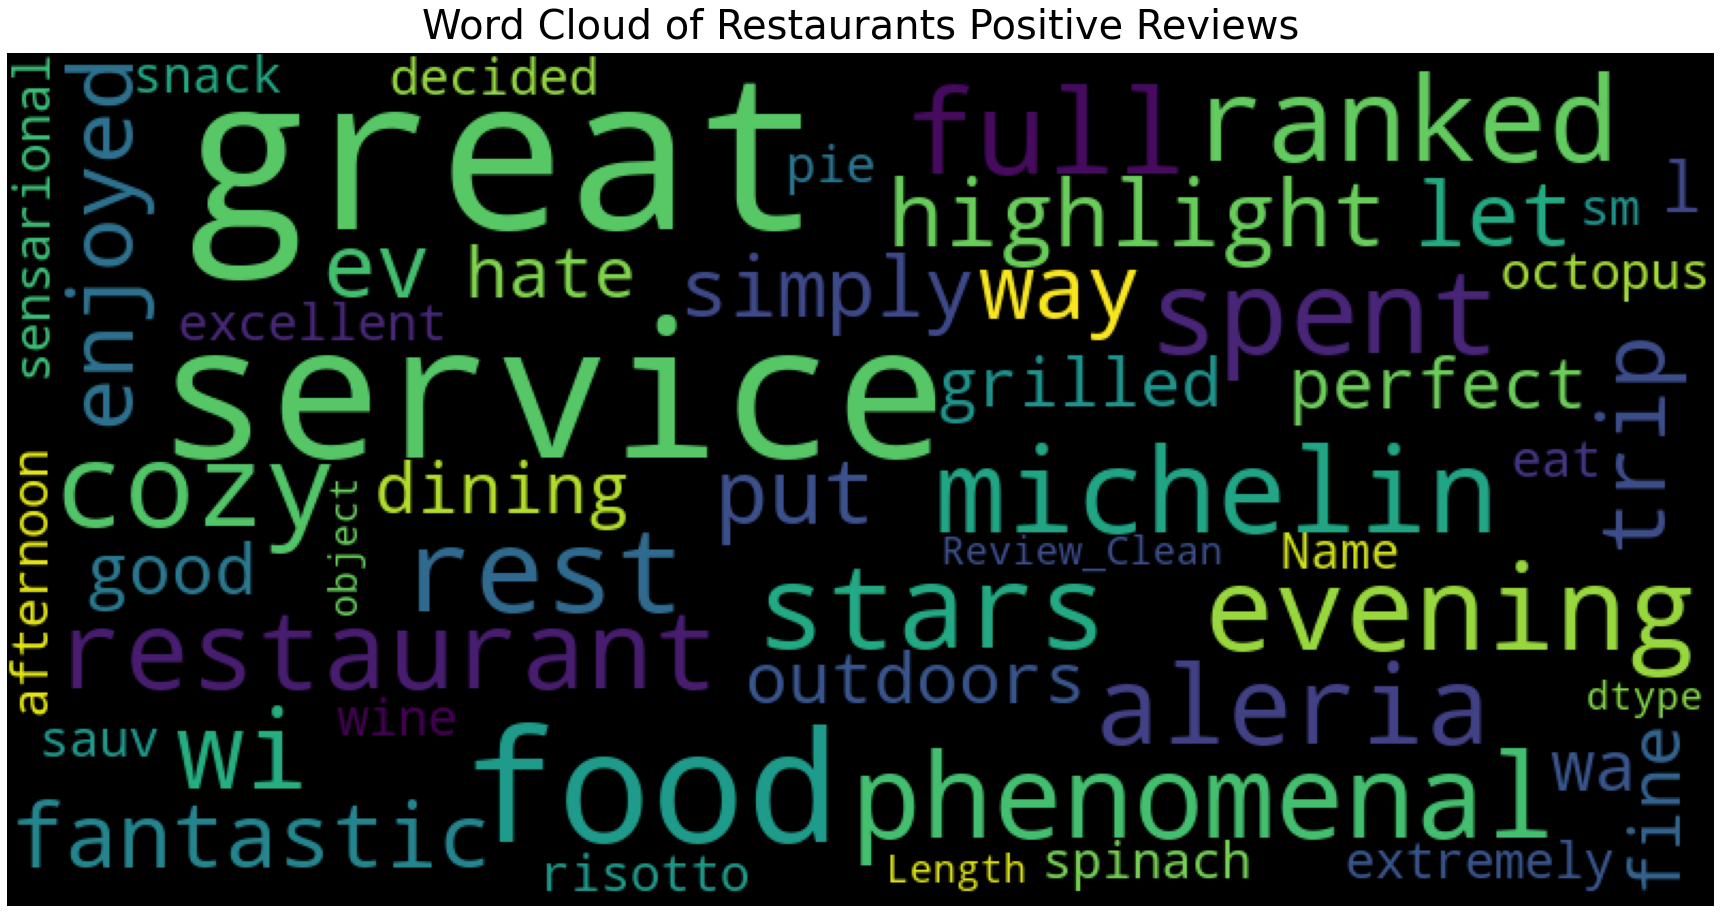

In [21]:
wordcloud.generate(str(df_pos['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Restaurants Positive Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

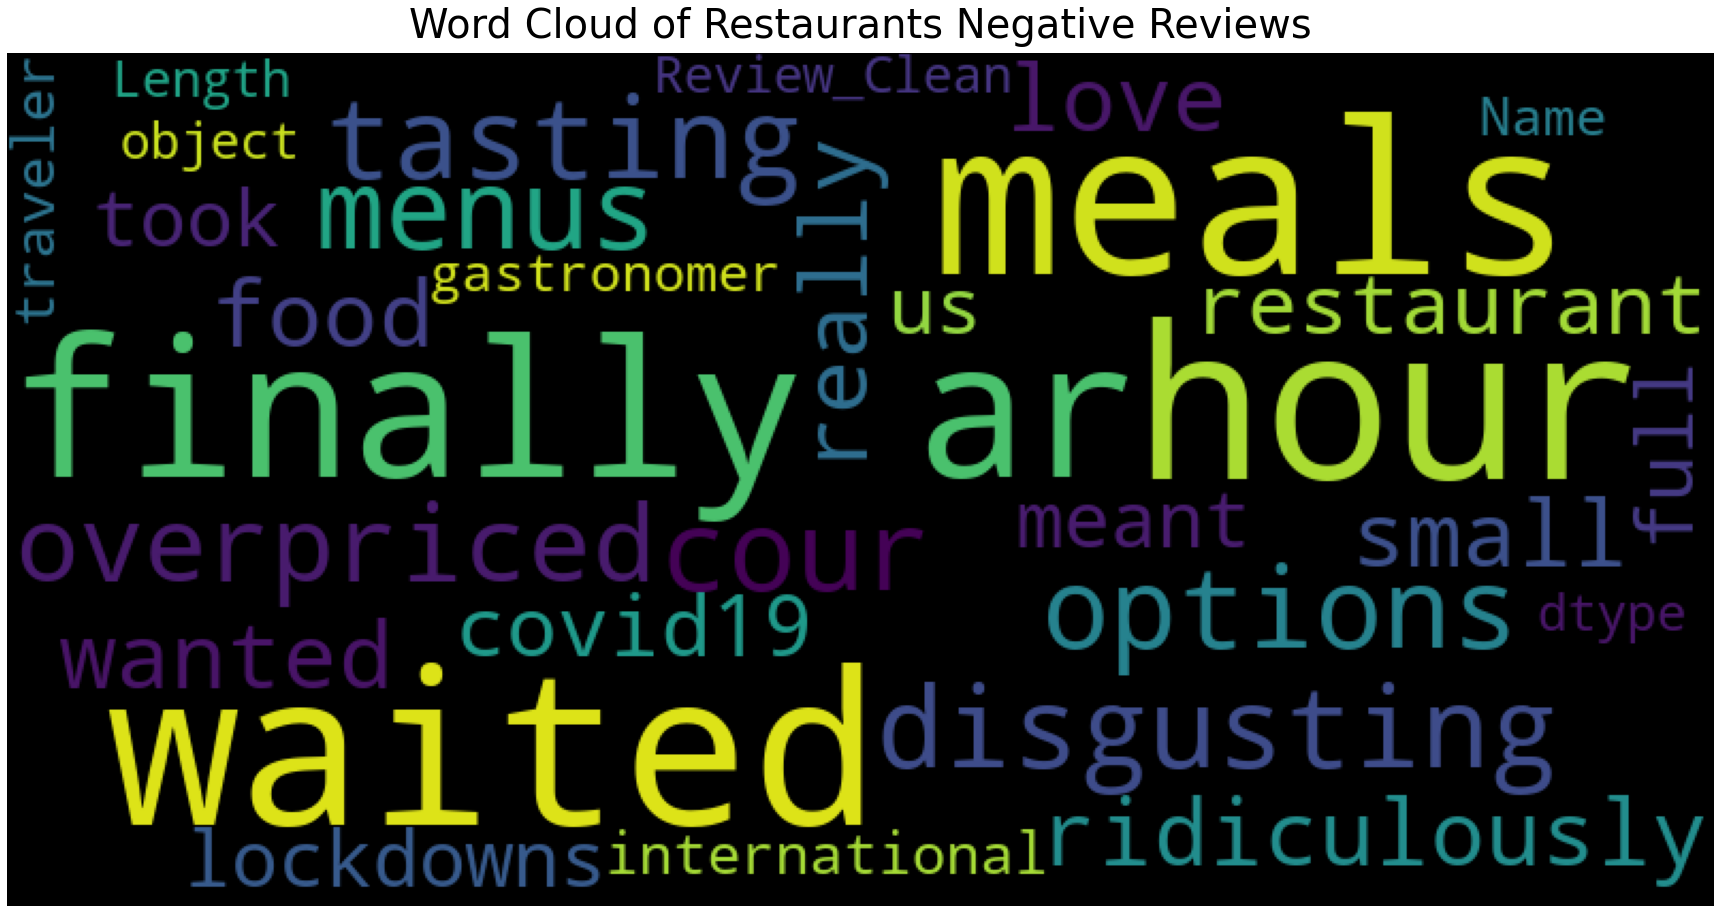

In [22]:
wordcloud.generate(str(df_neg['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Restaurants Negative Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

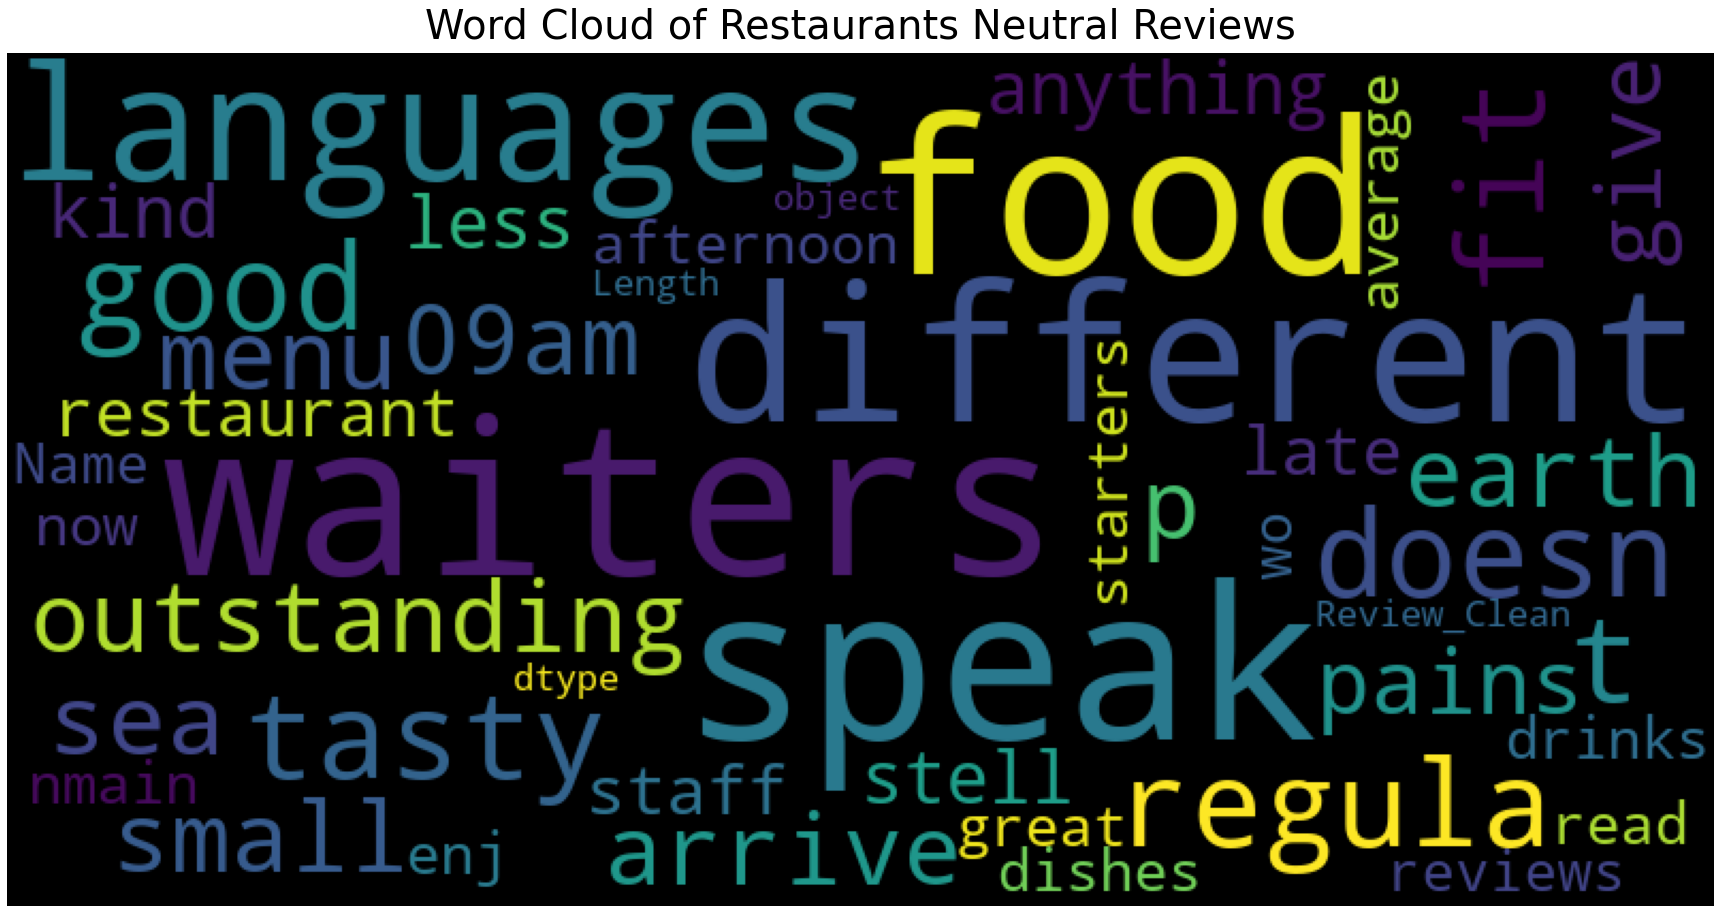

In [23]:
wordcloud.generate(str(df_notr['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Restaurants Neutral Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

Τα wordclouds δίνουν μια γενική ιδέα για το τι είναι κείμενο, αλλά χρειάζονται πιο χαρακτηριστικές λέξεις επειδή όλες οι λέξεις δεν βρίσκονται στο ίδιο κείμενο σε αυτά τα δεδομένα.

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
def word_count(reviews):
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

25 πιο κοινές λέξεις σε θετικές κριτικές

In [27]:
word_frequency=word_count(df_pos['Review_Clean'])

In [28]:
df_pos_count = pd.DataFrame(columns=['word', 'count'])
df_pos_count['word'] = word_frequency.keys()
df_pos_count['count'] = list(word_frequency.values())
df_pos_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_pos_count=df_pos_count.reset_index(drop=True)

In [29]:
stop_words = set(STOPWORDS)

In [30]:
stop = set(stopwords.words("english"))

Θα δημιουργήσω νέα στήλη ως word_without_stop και θα κάνουμε drop τη σειρά εάν περιέχει ενδιάμεσες λέξεις.

In [31]:
df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [32]:
df_pos_without_stop = df_pos_count.dropna(subset=['word_without_stop'])

In [33]:
df_top_25_pos = df_pos_count.loc[df_pos_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


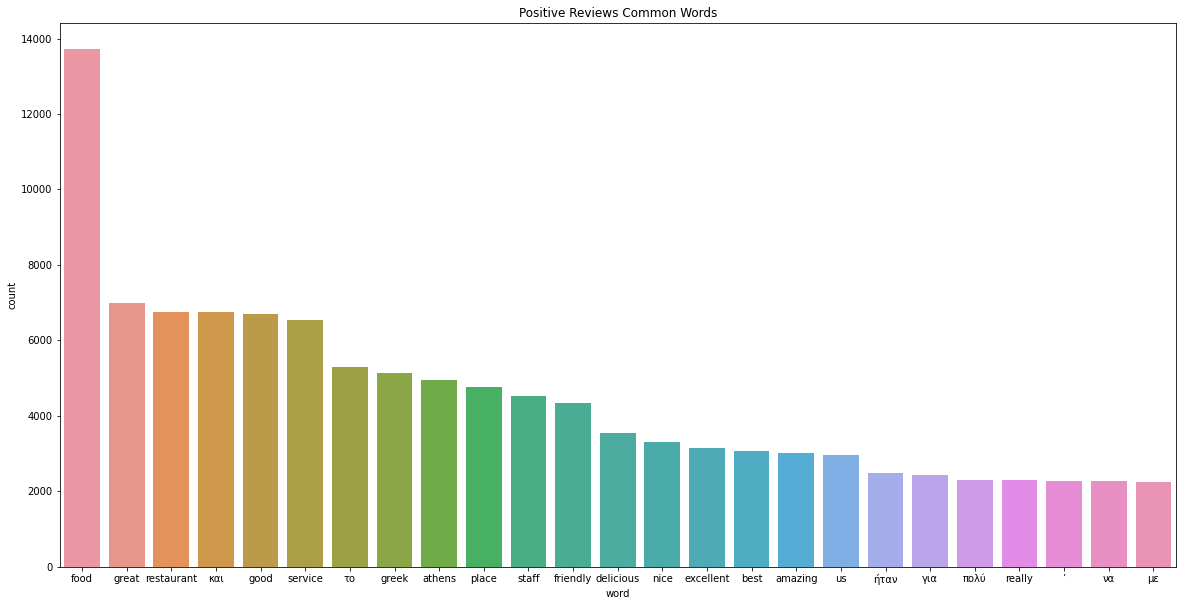

In [34]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot("word","count", data=df_top_25_pos)

25 πιο κοινές λέξεις σε αρνητικές κριτικές

In [35]:
word_frequency_neg=word_count(df_neg['Review_Clean'])

In [36]:
df_neg_count = pd.DataFrame(columns=['word', 'count'])
df_neg_count['word'] = word_frequency_neg.keys()
df_neg_count['count'] = list(word_frequency_neg.values())
df_neg_count=df_neg_count.sort_values(by=['count'], ascending=False)
df_neg_count=df_neg_count.reset_index(drop=True)

In [37]:
df_neg_count['word_without_stop'] = df_neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [38]:
df_neg_without_stop = df_neg_count.dropna(subset=['word_without_stop'])

In [39]:
df_top_25_neg = df_neg_count.loc[df_neg_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


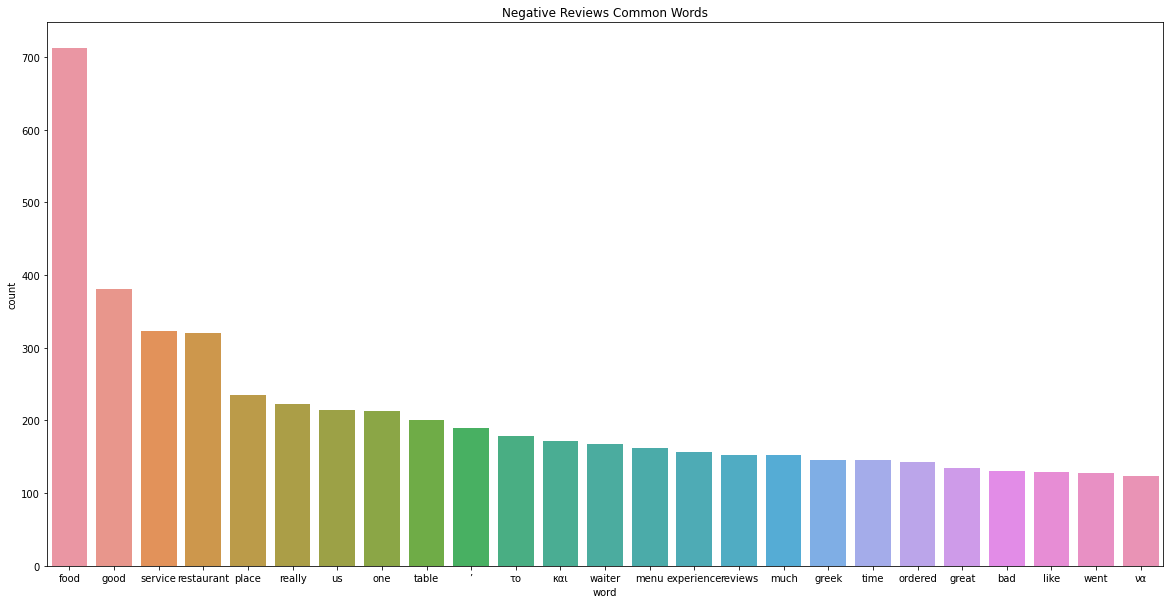

In [40]:
plt.figure(figsize=(20,10))
plt.title('Negative Reviews Common Words')
sns.barplot("word","count", data=df_top_25_neg)

25 πιο κοινές λέξεις σε neutral κριτικές

In [41]:
word_frequency_notr = word_count(df_notr['Review_Clean'])

In [42]:
df_nt_count = pd.DataFrame(columns=['word', 'count'])
df_nt_count['word'] = word_frequency_notr.keys()
df_nt_count['count'] = list(word_frequency_notr.values())
df_nt_count=df_nt_count.sort_values(by=['count'], ascending=False)
df_nt_count=df_nt_count.reset_index(drop=True)

In [43]:
df_nt_count['word_without_stop'] = df_nt_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [44]:
df_nt_without_stop = df_nt_count.dropna(subset=['word_without_stop'])

In [45]:
df_top_25_nt = df_nt_count.loc[df_nt_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


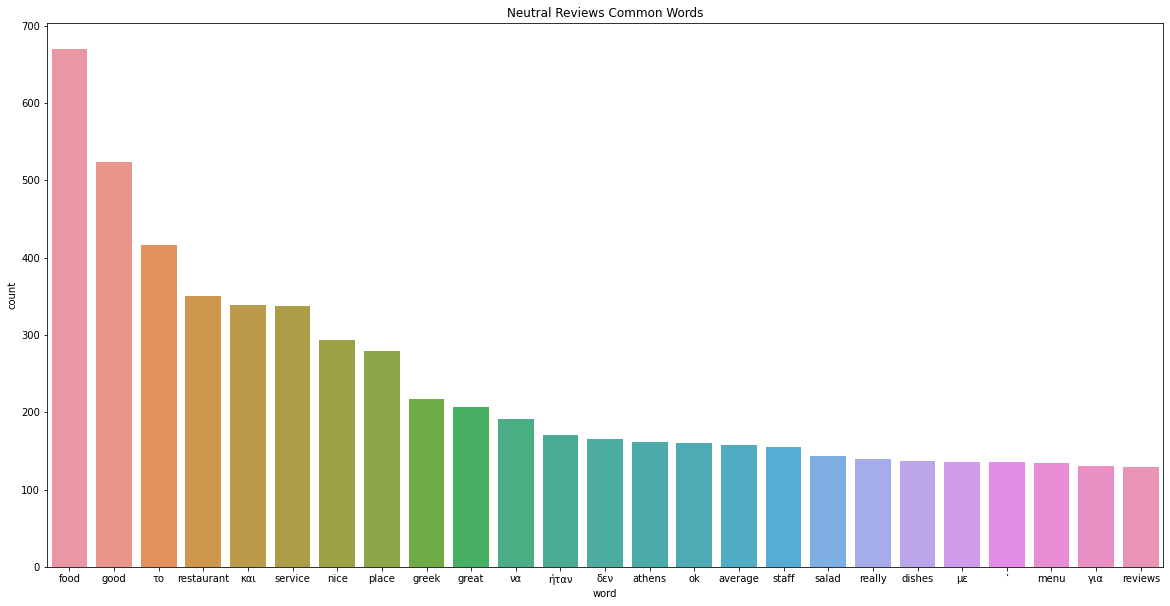

In [46]:
plt.figure(figsize=(20,10))
plt.title('Neutral Reviews Common Words')
sns.barplot("word","count", data=df_top_25_nt)

Παρατηρούμε παρόμοια αποτελέσματα. Πιθανότατα, ο λόγος είναι ότι ο υπολογιστής μετράει κάθε λέξη και αφαιρεί τα stopwords όπως το «δεν». Εάν οι πιο συνηθισμένες λέξεις είναι "δεν μου άρεσε" για αρνητικό, μετράται ως "μου αρέσει".

In [47]:
df

,Name,UserId,Review,Rating,sentiment,Review_Clean
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...
1,aleria,2,we spent great evening here. cozy restaurant w...,5,2,we spent great evening here cozy restaurant wi...
2,aleria,3,10/10. aleria was our highlight during our tri...,5,2,1010 aleria was our highlight during our trip ...
3,aleria,4,great service and fantastic food. we enjoyed e...,5,2,great service and fantastic food we enjoyed ev...
4,aleria,5,let me put it his way: simply perfect. we hate...,5,2,let me put it his way simply perfect we hate l...
...,...,...,...,...,...,...
26203,ydria,1000,"very good grilled octopus, spinach pie and sau...",5,2,very good grilled octopus spinach pie and sauv...
26204,ydria,1001,"the food is sensarional, the service is great....",5,2,the food is sensarional the service is great \...
26205,ydria,1002,risotto was excellent. wine was an extremely s...,4,2,risotto was excellent wine was an extremely sm...
26206,ydria,1003,we decided to eat here for an afternoon snack ...,5,2,we decided to eat here for an afternoon snack ...


In [48]:
df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Restaurants Reviews/cleaned_data.csv', index = False)

In [49]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε χρήστη
df['Reviewer_Count'] = df['UserId'].map(df['UserId'].value_counts())

In [50]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε εστιατορείου
df['Restaurant_Count'] = df['Name'].map(df['Name'].value_counts())

In [51]:
df = df.sort_values(by=['Reviewer_Count'],ascending=False)

In [52]:
df

,Name,UserId,Review,Rating,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...,30,886
11680,lithos,285,"amazing food, amazing service! a place that wi...",5,2,amazing food amazing service a place that will...,30,1005
11652,lithos,257,great restaurant with delicious food and great...,5,2,great restaurant with delicious food and great...,30,1005
11653,lithos,258,"great food and great service minded staff, hig...",5,2,great food and great service minded staff high...,30,1005
11654,lithos,259,we visited this restaurant in july 2021. we we...,5,2,we visited this restaurant in july 2021 we wer...,30,1005
...,...,...,...,...,...,...,...,...
8832,gods_restaurant,1005,"xcellent food, had a chicken souvlaki and grea...",5,2,xcellent food had a chicken souvlaki and great...,11,1005
9837,karamanlidika,1005,this place is spectacular. recommended by two...,5,2,this place is spectacular recommended by two ...,11,1005
6832,efcharis,1005,we visited efxaris for lunch. great lamb shop...,4,2,we visited efxaris for lunch great lamb shops...,11,1005
16602,oroscopo,1005,my 11 year old son picked this restaurant befo...,5,2,my 11 year old son picked this restaurant befo...,11,1005


In [53]:
df.reset_index(drop=True,inplace=True) 

In [54]:
df.isna().sum()

Name                0
UserId              0
Review              0
Rating              0
sentiment           0
Review_Clean        0
Reviewer_Count      0
Restaurant_Count    0
dtype: int64

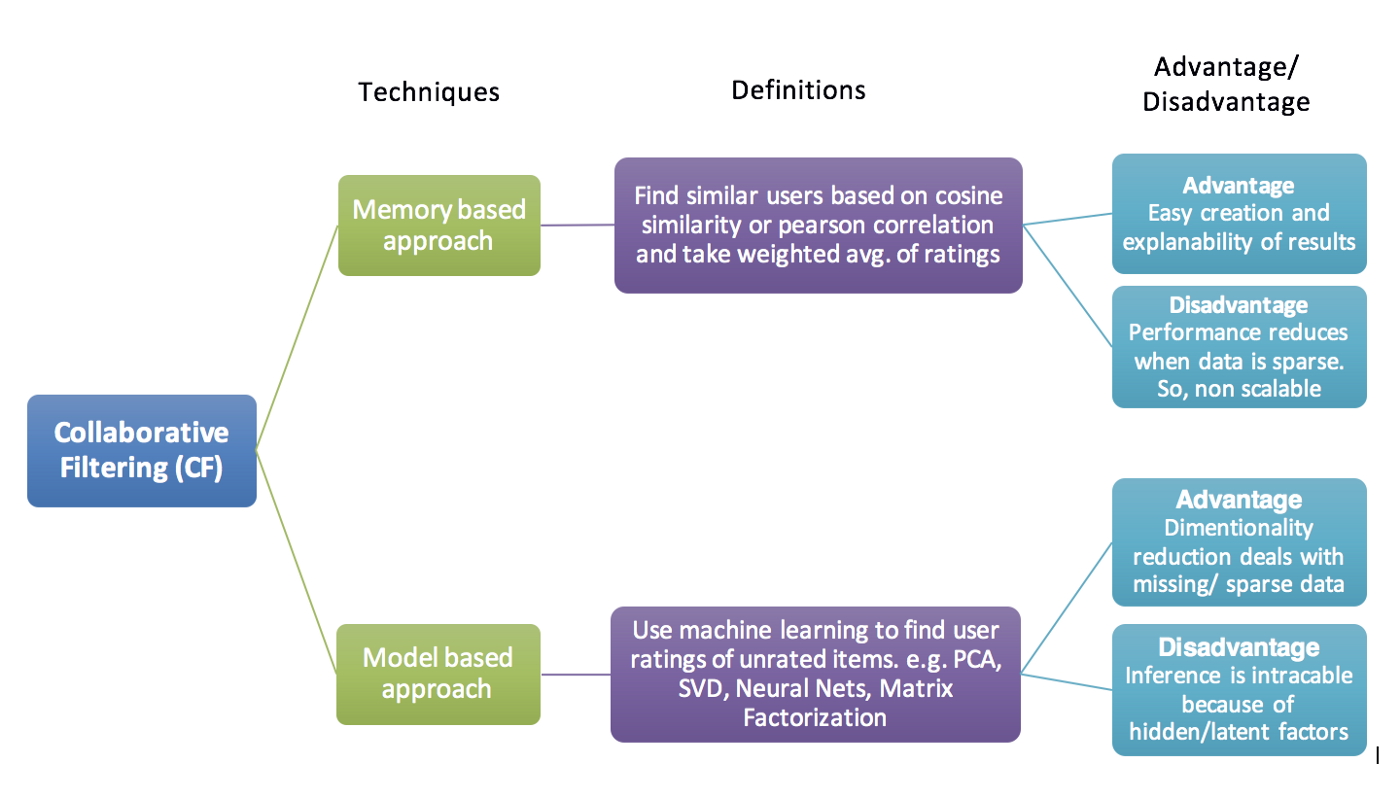

# Recommend with SVD - User Based

In [88]:
# κάνουμε pivot τον πίνακα
pivot = pd.pivot_table(df, index='UserId', columns=['Name'], values='Rating').fillna(0)
pivot.head(5)

Name,aleria,alexander_the_great,arcadia,athenascook,atitamos,balcony,dio_dekares,efcharis,elaea,gods_restaurant,...,rozalia,scholarchio,sin_athina,smile,strofi,the_greco,to_kati_allo,to_paradosiako,tzitzikas_kai_mermigas,ydria
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,1.0,5.0,3.0,4.0,4.0,5.0,5.0,4.0
10,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,...,5.0,5.0,1.0,5.0,5.0,5.0,2.0,1.0,5.0,5.0
100,5.0,5.0,5.0,5.0,4.0,1.0,5.0,5.0,5.0,5.0,...,5.0,4.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0
1000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,5.0
1001,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,0.0,5.0


In [89]:
pivot_mat = pivot.values
pivot_mat[:5]

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        4., 4., 4., 5., 5., 5., 1., 5., 3., 4., 4., 5., 5., 4.],
       [3., 5., 5., 5., 5., 5., 5., 3., 5., 4., 5., 5., 5., 5., 4., 4.,
        5., 5., 5., 5., 5., 5., 1., 5., 5., 5., 2., 1., 5., 5.],
       [5., 5., 5., 5., 4., 1., 5., 5., 5., 5., 5., 3., 5., 5., 5., 5.,
        5., 5., 3., 5., 5., 4., 5., 5., 3., 4., 5., 5., 5., 5.],
       [0., 0., 2., 0., 0., 0., 0., 5., 0., 5., 5., 0., 1., 5., 5., 0.,
        0., 0., 5., 5., 0., 0., 0., 5., 5., 0., 2., 0., 0., 5.],
       [0., 0., 5., 0., 0., 0., 0., 5., 0., 5., 5., 0., 1., 5., 5., 0.,
        0., 0., 4., 2., 0., 0., 0., 5., 5., 0., 5., 0., 0., 5.]])

In [90]:
# Η στήλη user id είναι index, οπότε το αποθηκεύουμαι σε μια λίστα
user_id = list(pivot.index)
user_id[:10]

['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '101']

In [91]:
sparse_matrix = csr_matrix(pivot_mat)
sparse_matrix

<1005x30 sparse matrix of type '<class 'numpy.float64'>'
	with 26208 stored elements in Compressed Sparse Row format>

In [92]:
# αριθμοί factor για τον πίνακα
factor_n = 15

In [93]:
# παραγοντοποίηση πίνακα
U, sigma, V = svds(sparse_matrix, k = factor_n)

In [94]:
# διαστάσεις πίνακα
print(U.shape)
print(V.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(1005, 15)
(15, 30)
(15, 15)


In [95]:
pred_rating = np.dot(np.dot(U,sigma),V)
pred_rating[:5]

array([[ 5.10613796e+00,  4.48722673e+00,  4.73475454e+00,
         4.80621782e+00,  4.88183062e+00,  4.99760712e+00,
         4.92093591e+00,  4.91894820e+00,  4.55732936e+00,
         5.12886634e+00,  4.69241383e+00,  4.80996617e+00,
         4.67473774e+00,  4.74052777e+00,  4.58930268e+00,
         4.79756014e+00,  4.70888040e+00,  3.37815040e+00,
         4.13234416e+00,  4.75116760e+00,  4.98197478e+00,
         4.76352790e+00,  1.48021573e+00,  5.29080624e+00,
         3.64439301e+00,  4.45698935e+00,  5.14757571e+00,
         5.13658934e+00,  5.19350454e+00,  4.23808976e+00],
       [ 3.19354890e+00,  4.90139685e+00,  4.71795166e+00,
         4.72672059e+00,  4.01562508e+00,  4.18279720e+00,
         4.85766835e+00,  4.56595318e+00,  4.09417081e+00,
         3.62233758e+00,  4.72412825e+00,  4.68605094e+00,
         4.53730325e+00,  4.67957329e+00,  4.35058389e+00,
         4.73006326e+00,  5.15064281e+00,  2.96233087e+00,
         4.70789415e+00,  4.81844414e+00,  5.04295886e+

Πρέπει να κανονικοποιήσω τον πίνακα μου πριν το recommendation λόγω μηδενικών τιμών.

In [96]:
# κανονικοποίηση
pred_rating_n = (pred_rating - pred_rating.min()) / (pred_rating.max() - pred_rating.min())

In [97]:
pred_rating_n[:5]

array([[0.8407907 , 0.7656044 , 0.79567447, 0.80435594, 0.8135415 ,
        0.8276062 , 0.81829207, 0.8180506 , 0.77412058, 0.84355178,
        0.79053085, 0.80481129, 0.78838353, 0.79637581, 0.77800475,
        0.80330419, 0.79253124, 0.63087209, 0.72249272, 0.79766835,
        0.82570716, 0.7991699 , 0.40030805, 0.86322449, 0.66321566,
        0.76193112, 0.84582462, 0.84448998, 0.85140413, 0.73533886],
       [0.60844642, 0.81591843, 0.79363323, 0.79469849, 0.70831351,
        0.72862183, 0.81060623, 0.77516822, 0.71785536, 0.66053633,
        0.79438357, 0.78975788, 0.77168778, 0.78897096, 0.74900482,
        0.79510456, 0.84619722, 0.58035769, 0.79241142, 0.80584121,
        0.83311561, 0.81116409, 0.47809566, 0.84132538, 0.95141678,
        0.76687139, 0.60525718, 0.49135911, 0.89230072, 0.86595412],
       [0.80151788, 0.83183883, 0.80231375, 0.85023798, 0.75741491,
        0.76044137, 0.81395864, 0.81431208, 0.77086963, 0.87142482,
        0.8009197 , 0.60470977, 0.81193304, 0.

In [98]:
# ανάθεση του νέου πίνακα στο dataframes
pred_df = pd.DataFrame(pred_rating_n, columns = pivot.columns, index=user_id).transpose()
pred_df.head(15)

,1,10,100,1000,1001,1002,1003,1004,1005,101,...,990,991,992,993,994,995,996,997,998,999
Name,,,,,,,,,,,,,,,,,,,,,
aleria,0.840791,0.608446,0.801518,0.204087,0.174247,0.188270,0.182627,0.211295,0.228816,0.819235,...,0.244361,0.213906,0.198929,0.196258,0.195678,0.203288,0.175666,0.170026,0.188437,0.169834
alexander_the_great,0.765604,0.815918,0.831839,0.200962,0.210047,0.236527,0.225588,0.229142,0.230917,0.837330,...,0.204892,0.220414,0.236888,0.211031,0.239314,0.229476,0.236909,0.223250,0.213933,0.243060
arcadia,0.795674,0.793633,0.802314,0.693833,0.721865,0.763123,0.770282,0.682637,0.678879,0.746879,...,0.770883,0.813195,0.734603,0.806163,0.784981,0.762467,0.774586,0.781862,0.760503,0.724855
athenascook,0.804356,0.794698,0.850238,0.244472,0.279313,0.271596,0.272690,0.222515,0.211629,0.725136,...,0.171926,0.234824,0.246341,0.240240,0.254203,0.243429,0.279450,0.273371,0.247500,0.286322
atitamos,0.813541,0.708314,0.757415,0.336021,0.359900,0.381342,0.377768,0.332380,0.320442,0.747705,...,0.720153,0.556052,0.470288,0.471763,0.486504,0.483412,0.421213,0.426928,0.400100,0.404514
balcony,0.827606,0.728622,0.760441,0.321844,0.344877,0.356613,0.366912,0.327815,0.318894,0.759458,...,0.684982,0.514497,0.422139,0.446980,0.466250,0.431586,0.371548,0.395491,0.375226,0.386707
dio_dekares,0.818292,0.810606,0.813959,0.228063,0.212754,0.215067,0.217100,0.231729,0.241280,0.868670,...,0.231196,0.205565,0.217607,0.215192,0.216982,0.218167,0.225375,0.226762,0.233611,0.215141
efcharis,0.818051,0.775168,0.814312,0.716507,0.735800,0.780836,0.776106,0.693774,0.707311,0.787378,...,0.743686,0.794018,0.731814,0.803179,0.757517,0.747324,0.800941,0.783022,0.769021,0.706325
elaea,0.774121,0.717855,0.770870,0.387169,0.419060,0.454442,0.450911,0.387066,0.365706,0.741970,...,0.801428,0.668511,0.592656,0.566250,0.603438,0.626038,0.524922,0.543284,0.492267,0.505442


Τώρα,υπάρχει η παραγοντοποίηση SVD κάθε χρήστη για κάθε εστιατόριο. Είναι ώρα για την τα recommendations.

In [99]:
def recommend_restaurants(user_id ,pred_df, items_df, items_to_ignore=[], top_list=20, verbose=False):
      
        # αυτή η συνάρτηση βρήσκει τα πιο σχετικά στοιχεία
        sorted_user_predictions = pred_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Name'].isin(items_to_ignore)].sort_values(by='recStrength', ascending = False).head(top_list)
        print(recommendations_df)
        return recommendations_df


In [100]:
def recommender(user_id,pred_df,real_df,df_meta):
   
    #αυτή η συνάρτησησ συγχωνεύει τον τίτλο με το αντίστοιχο αναγνωριστικό εστιατορίου και βρίσκει τις κενές σειρές δηλαδή τα εστιατόρεια που δεν έχει επισκεφθεί ο χρήστης
    restaurants_to_ignore = df[df['UserId'] == str(user_id)]['Name'].values
    recommend = recommend_restaurants(user_id, pred_df,real_df, restaurants_to_ignore)
    df_user= real_df.loc[real_df['UserId'] == user_id]
    new_df = df_user.merge(recommend, how = 'outer', left_on = 'Name', right_on = 'Name')
    rec_df = new_df.loc[new_df['Rating'].isnull()==True]
    df_rec_t = rec_df.loc[:, ['Name', 'recStrength']]
    df_last = pd.merge(df_rec_t,df_meta[['RestaurantId','Name']],on=['Name'], how='left')
    df_last = df_last.drop_duplicates(subset=["Name", "RestaurantId"], keep='first')
    df_last = df_last.reset_index(drop=True) 
    return df_last

In [101]:
restaurants = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Restaurants Reviews/restaurants.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Restaurants Reviews/ratings.csv')
df_meta = restaurants.merge(ratings, how="left", on="RestaurantId")
df_meta = df_meta.astype({"UserId": str, "RestaurantId": str})
df_meta.head()

,RestaurantId,Name,UserId,Review,Rating
0,1,aleria,1,A full 5 stars! Phenomenal Michelin ranked res...,5
1,1,aleria,2,We spent great evening here. Cozy restaurant w...,5
2,1,aleria,3,10/10. Aleria was our highlight during our tri...,5
3,1,aleria,4,Great service and fantastic food. We enjoyed e...,5
4,1,aleria,5,Let me put it his way: simply perfect. We hate...,5


In [102]:
df = df.astype({"UserId": str})
df

,Name,UserId,Review,Rating,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...,30,886
1,lithos,285,"amazing food, amazing service! a place that wi...",5,2,amazing food amazing service a place that will...,30,1005
2,lithos,257,great restaurant with delicious food and great...,5,2,great restaurant with delicious food and great...,30,1005
3,lithos,258,"great food and great service minded staff, hig...",5,2,great food and great service minded staff high...,30,1005
4,lithos,259,we visited this restaurant in july 2021. we we...,5,2,we visited this restaurant in july 2021 we wer...,30,1005
...,...,...,...,...,...,...,...,...
26203,gods_restaurant,1005,"xcellent food, had a chicken souvlaki and grea...",5,2,xcellent food had a chicken souvlaki and great...,11,1005
26204,karamanlidika,1005,this place is spectacular. recommended by two...,5,2,this place is spectacular recommended by two ...,11,1005
26205,efcharis,1005,we visited efxaris for lunch. great lamb shop...,4,2,we visited efxaris for lunch great lamb shops...,11,1005
26206,oroscopo,1005,my 11 year old son picked this restaurant befo...,5,2,my 11 year old son picked this restaurant befo...,11,1005


In [103]:
recommender(str(1000),pred_df,df,df_meta)

                      Name  recStrength
13                   elaea     0.387169
14                atitamos     0.336021
15                 balcony     0.321844
16                   nolan     0.314612
17               mani_mani     0.252015
18             athenascook     0.244472
19             scholarchio     0.235359
20             dio_dekares     0.228063
21              klimataria     0.218106
22               the_greco     0.217771
23                  mironi     0.212164
24                  aleria     0.204087
25     alexander_the_great     0.200962
26  tzitzikas_kai_mermigas     0.196950
27                 rozalia     0.190623
28              sin_athina     0.144441
29          to_paradosiako     0.007869


,Name,recStrength,RestaurantId
0,elaea,0.387169,9
1,atitamos,0.336021,5
2,balcony,0.321844,6
3,nolan,0.314612,18
4,mani_mani,0.252015,16
5,athenascook,0.244472,4
6,scholarchio,0.235359,22
7,dio_dekares,0.228063,7
8,klimataria,0.218106,12
9,the_greco,0.217771,26


# Recommend with Cosine Similarity - User Based

In [104]:
user_sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
user_recommender = pw.cosine_similarity(user_sparse_pivot)

In [105]:
pred_rating_n_cos = (user_recommender - user_recommender.mean())/ (user_recommender.max() - user_recommender.min())

In [106]:
user_recommender_df = pd.DataFrame(pred_rating_n_cos, columns=pivot.index.values,index = pivot.index.values)

Στην μέθοδο αυτή, έχουμε ένα user-user matrix, που δείχνει τις σχέσεις τους και με βάζει αυτόν θα γίνουν οι συστάσεις.

In [107]:
user_recommender_df.head(3)

,1,10,100,1000,1001,1002,1003,1004,1005,101,...,990,991,992,993,994,995,996,997,998,999
1,0.229532,0.164718,0.160663,-0.579102,-0.568150,-0.514393,-0.514393,-0.563569,-0.579366,0.166507,...,-0.323952,-0.388335,-0.483215,-0.418556,-0.415592,-0.476578,-0.492175,-0.491895,-0.486807,-0.530926
10,0.164718,0.229532,0.093526,-0.565311,-0.589295,-0.531308,-0.531308,-0.523085,-0.582571,0.111156,...,-0.362774,-0.369762,-0.498678,-0.411255,-0.414070,-0.475580,-0.495561,-0.482164,-0.444946,-0.526090
100,0.160663,0.093526,0.229532,-0.563978,-0.533274,-0.490269,-0.480793,-0.569155,-0.590299,0.167767,...,-0.309780,-0.278928,-0.370202,-0.359922,-0.332054,-0.333297,-0.364099,-0.366651,-0.412392,-0.485258


In [108]:
def recommend2(user_recommender_df,user_id,df_meta):
    #Αυτή η συνάρτηση βρίσκει πρώτα τους 2 πιο όμοιους χρήστες και μετά 
    #παίρνει τον μέσο όρο των αξιολογήσεών τους στα εστιατόρεια και τα ταξινομεί σύμφωνα με τις μέσες τιμές
    user_cosine_df = pd.DataFrame(user_recommender_df[user_id].sort_values(ascending=False))
    user_cosine_df.reset_index(level=0, inplace=True)
    user_cosine_df.columns = ['Name','cosine_sim']
    
    # για 2 όμοιους χρήστες
    similar_user = list(user_cosine_df['Name'][1:3].values)
    similar_user_df = pivot.T[[user_id] + similar_user]
    similar_user_df['mean'] = similar_user_df[similar_user].mean(numeric_only=True,axis=1)
    similar_user_df.sort_values('mean', ascending=False,inplace = True)
    
    # πέρνουμε 10 εστιατόρια από παρόμοιους χρήστες και γίνεται η συγχώνευσή τους
    restaurant_top10 = similar_user_df[similar_user_df[user_id]==0].head(10)
    df_last1 = pd.merge(restaurant_top10,df_meta[['RestaurantId','Name']],on=['Name'], how='left')
    df_last1 = df_last1.drop_duplicates(subset=["Name", "RestaurantId"], keep='first')
    df_last1 = df_last1.reset_index(drop=True) 
    return df_last1

In [110]:
recommend2(user_recommender_df,str(500),df_meta)

,Name,500,499,494,mean,RestaurantId
0,rozalia,0.0,0.0,0.0,0.0,21
1,dio_dekares,0.0,0.0,0.0,0.0,7


# Recommendations from Keywords

## Recommending based on cosine similarity of reviews

In [120]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import math
from collections import Counter
import operator

In [121]:
stop = set(stopwords.words("english")) #σετάρουμε τα stopwords

In [122]:
df

,Name,UserId,Review,Rating,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...,30,886,full 5 stars phenomenal michelin ranked restau...
1,lithos,285,"amazing food, amazing service! a place that wi...",5,2,amazing food amazing service a place that will...,30,1005,amazing food amazing service place complete va...
2,lithos,257,great restaurant with delicious food and great...,5,2,great restaurant with delicious food and great...,30,1005,great restaurant delicious food great service ...
3,lithos,258,"great food and great service minded staff, hig...",5,2,great food and great service minded staff high...,30,1005,great food great service minded staff highly r...
4,lithos,259,we visited this restaurant in july 2021. we we...,5,2,we visited this restaurant in july 2021 we wer...,30,1005,visited restaurant july 2021 family 5 tables s...
...,...,...,...,...,...,...,...,...,...
26203,gods_restaurant,1005,"xcellent food, had a chicken souvlaki and grea...",5,2,xcellent food had a chicken souvlaki and great...,11,1005,xcellent food chicken souvlaki great service p...
26204,karamanlidika,1005,this place is spectacular. recommended by two...,5,2,this place is spectacular recommended by two ...,11,1005,place spectacular recommended two athenian fri...
26205,efcharis,1005,we visited efxaris for lunch. great lamb shop...,4,2,we visited efxaris for lunch great lamb shops...,11,1005,visited efxaris lunch great lamb shops great c...
26206,oroscopo,1005,my 11 year old son picked this restaurant befo...,5,2,my 11 year old son picked this restaurant befo...,11,1005,11 year old son picked restaurant came athens ...


In [123]:
df['word_without_stop'] = df['Review_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [124]:
def cosine_similarity_of(text1, text2):
        
        # διαβάζουμε τις λέξεις
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        # δημιουργεία λεξιλογίου
        vector1 = Counter(first)
        vector2 = Counter(second)

        # αλλάζοντας διανύσματα σε σύνολα για να βρούμε κοινές λέξεις με τομή
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
          
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        # άθροισμα των μετρήσεων λέξεων για κάθε διάνυσμα
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        # υπολογισμός του μεγέθους του διανύσματος με άθροισμα τετραγώνων
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [125]:
text1 = df['word_without_stop'][1] 
text2 = df['word_without_stop'][2] 
cosine_similarity_of(text1, text2)

0.16692446522239712

In [126]:
def get_recommendations(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            score_dict[index] = cosine_similarity_of(row['word_without_stop'], keywords)

        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similarities
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('UserId', 'Name','word_without_stop', 'score'))

        # κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
            result = result.append({'UserId': df.iloc[i[0]]['UserId'], 
                                        'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break

        return result



In [127]:
keywords = "best place ever"

In [128]:
top_10= get_recommendations(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,UserId,Name,word_without_stop,score
0,458,efcharis,great place best hospitality athens fully reco...,0.560112
1,491,elaea,best place eat athens best food i’ve ever trie...,0.545545
2,503,alexander_the_great,gathered reccomandation friend best food ever ...,0.536056
3,60,liondi,looking great greece experience place best ser...,0.529813
4,640,maiandros,husband went back favorite place loyal custome...,0.522233
5,117,karamanlidika,authentic place great service extensive menu d...,0.516398
6,465,to_paradosiako,best food excellent service beautiful place lo...,0.500000
7,83,sin_athina,nervous book place athens im ive never happier...,0.471405
8,62,aleria,best experience ever like astonished taste rea...,0.471405
9,675,oroscopo,service att place far best ever stumbled upon ...,0.471405


## Rating Effect Adding

θα προσθέσω ένα weight του rating στη λειτουργία του συστήματος. Για να γίνει αυτό, θα καθορίσω πόσο θέλω να επηρεάστουν τα αποτελέσματα. Θα χρησιμοποιήσω απλή μαθηματική εξίσωση, weigth = (2*Q/5)*rating - Q. 

Το Q καθορίζει πόσο θα επηρεάσει. Για Q=10 και rating = 5, το cosine similarity αυξάνεται κατά 10%.

In [129]:
def rating_weight(rating,Q):
    #υπολογισμός του βάρους του rating
    w = (2*Q/5)*rating - Q
    return w

In [130]:
def calculate_final_score(cos_sim, w):
        # προσθέτοντας την επίδραση του βάρους στο cosine similarity
        effect = (cos_sim / 100) * w
        return cos_sim + effect

In [131]:
def get_recommendations_rat(df,keywords):
        score_dict = {}

        for index, row in df.iterrows():
            cs_score = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            
            # Επιλέγουμε Q=10
            rating_effect = rating_weight(rating,10)

            last_score = calculate_final_score(cs_score, rating_effect)

            score_dict[index] = last_score
            
        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similaritiess
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

         #  κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
              

            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result



In [132]:
keywords = "best restaurant ever"

In [133]:
top_10= get_recommendations_rat(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,alexander_the_great,first restaurant visited best great food local...,5,0.635085
1,smile,referred smile restaurant chef nearby restaura...,5,0.635085
2,to_paradosiako,family restaurant best moussaka ever fish also...,5,0.602495
3,gods_restaurant,love restaurant staff best best food desserts ...,5,0.598764
4,liondi,discover restaurant year ago came back year be...,5,0.587975
5,maiandros,maiandros restaurant give best traditional foo...,5,0.582794
6,nolan,best food ever sotiris contizas best chef far ...,5,0.552771
7,tzitzikas_kai_mermigas,fantastic lunch restaurant today aubergine sal...,5,0.541603
8,arcadia,best restaurant ever great location delicious ...,5,0.541603
9,lithos,andreas welcoming man entrance restaurant trea...,5,0.529698


## Number of Ratings Effect

Είναι δύσκολο να πούμε ότι το εστιατόριο που έχει μέση βαθμολογία 5 με μόνο 8 σχόλια είναι καλύτερο από το εστιατόριο που βαθμολογήθηκε με 4 με 2000 κριτικές. Περισσότερες κριτικές για το προϊόν σημαίνει μεγαλύτερη αξιοπιστία.

Έτσι, θα προσθέσω πολλαπλασιαστή στη συνάρτηση βαθμολόγησης που δίνει μικρότερο αποτέλεσμα εάν η βαθμολογία είναι μικρότερη από το όριο.

Θα χρησιμοποιήσουμε ως multipier to e^(({-t)*0.68)/ratingsnumber)

In [134]:
math.exp(-0.68) # όταν το t ισούται με τον αριθμό των ratings.

0.5066169923655895

In [135]:
def get_rating_weight_with_threshold(rating, count, threshold, Q):
            # υπολογισμός του βάρους του rating
            w = (2*Q/5)*rating - Q
            # multiplier
            M = math.exp((-threshold*0.68)/count)

            return w * M

In [136]:
df

,Name,UserId,Review,Rating,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop
0,aleria,1,a full 5 stars! phenomenal michelin ranked res...,5,2,a full 5 stars phenomenal michelin ranked rest...,30,886,full 5 stars phenomenal michelin ranked restau...
1,lithos,285,"amazing food, amazing service! a place that wi...",5,2,amazing food amazing service a place that will...,30,1005,amazing food amazing service place complete va...
2,lithos,257,great restaurant with delicious food and great...,5,2,great restaurant with delicious food and great...,30,1005,great restaurant delicious food great service ...
3,lithos,258,"great food and great service minded staff, hig...",5,2,great food and great service minded staff high...,30,1005,great food great service minded staff highly r...
4,lithos,259,we visited this restaurant in july 2021. we we...,5,2,we visited this restaurant in july 2021 we wer...,30,1005,visited restaurant july 2021 family 5 tables s...
...,...,...,...,...,...,...,...,...,...
26203,gods_restaurant,1005,"xcellent food, had a chicken souvlaki and grea...",5,2,xcellent food had a chicken souvlaki and great...,11,1005,xcellent food chicken souvlaki great service p...
26204,karamanlidika,1005,this place is spectacular. recommended by two...,5,2,this place is spectacular recommended by two ...,11,1005,place spectacular recommended two athenian fri...
26205,efcharis,1005,we visited efxaris for lunch. great lamb shop...,4,2,we visited efxaris for lunch great lamb shops...,11,1005,visited efxaris lunch great lamb shops great c...
26206,oroscopo,1005,my 11 year old son picked this restaurant befo...,5,2,my 11 year old son picked this restaurant befo...,11,1005,11 year old son picked restaurant came athens ...


In [137]:
def get_recommendations_rat_count(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            threshold = 110
           
            rating_contribution = get_rating_weight_with_threshold(rating,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)

            score_dict[index] = last_score
            
     
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0


        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))
        
        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result

In [138]:
keywords = "best restaurant ever"
top_10 = get_recommendations_rat_count(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,smile,referred smile restaurant chef nearby restaura...,5,0.630944
1,alexander_the_great,first restaurant visited best great food local...,5,0.628969
2,to_paradosiako,family restaurant best moussaka ever fish also...,5,0.598509
3,gods_restaurant,love restaurant staff best best food desserts ...,5,0.594860
4,liondi,discover restaurant year ago came back year be...,5,0.584141
5,maiandros,maiandros restaurant give best traditional foo...,5,0.578994
6,nolan,best food ever sotiris contizas best chef far ...,5,0.549146
7,arcadia,best restaurant ever great location delicious ...,5,0.538071
8,tzitzikas_kai_mermigas,fantastic lunch restaurant today aubergine sal...,5,0.537945
9,lithos,andreas welcoming man entrance restaurant trea...,5,0.526244


## Positive Review Effect

Τώρα, θέλω να δώσω μεγαλύτερη βαρύτητα στη βαθμολογία μου εάν η κριτική είναι θετική. Για να γίνει αυτό, θα δημιουργήσω νέες στήλες που είναι True όταν η βαθμολογία είναι ίση ή μεγαλύτερη από 3.

Θέτουμε newrating = rating + (7 - rating)/2 = (rating+7)/2

In [139]:
df['positive'] = df['Rating'].apply(lambda x: True if x>=3 else False)

In [140]:
def get_recommendations_rat_count_pos(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            
            if row['positive']==True:
                pos_rat = (7+rating)/2
            else:
                pos_rat = rating/2
                
            threshold=110
            
            rating_contribution =get_rating_weight_with_threshold(pos_rat,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)
   
            score_dict[index] = last_score

        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            
            counter += 1

            if counter>15:
                break
                
        return result

In [141]:
keywords = "best food ever"
top_10= get_recommendations_rat_count_pos(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,liondi,food service easily best ive ever greece lamb ...,5,0.748333
1,alexander_the_great,gathered reccomandation friend best food ever ...,5,0.723785
2,nolan,best food ever sotiris contizas best chef far ...,5,0.681356
3,arcadia,food excellent real greek food best traditiona...,5,0.673777
4,maiandros,best food ever nice atmosphere staff great fri...,5,0.673777
5,aleria,best experience ever like astonished taste rea...,5,0.665073
6,rozalia,best greek tavern ive ever authentic greek foo...,5,0.644730
7,gods_restaurant,best service ever think food good spinach pie ...,5,0.634982
8,elaea,best place eat athens best food i’ve ever trie...,5,0.616390
